# Scripting Sculptor 02 - Analysing model fits with SpecAnalysis

The next step after successfully fitting a model to the astronomical spectrum is the analysis of the model fit. The Sculptor *SpecAnalysis* module is designed to make this task easy with your Sculptor fit. While fitting a single function (e.g., a Gaussian) to an emission or absorption feature may be easy to analyze, deriving important quantities, such as the width, peak flux or equivalent width from multi-component line fits can be more tedious. Luckily, the *SpecAnalysis* module includes all of this functionality already. 

However, before we begin, we need to import the most important python packages. We will use numpy and the astropy.units and astropy.cosmology packages as well as the three sculptor modules *SpecOneD*, *SpecFit*, and - the topic of this notebook - *SpecAnalysis*.

**DISCLAIMER: At the moment the SpecAnalysis functions are written for model spectra in WAVELENGTH units. If you are working with a science spectrum in FREQUENCY units, please convert all model spectra to wavelength before using the *SpecAnalysis* functionality.**

**Note:** A lot of the functionality of the *SpecAnalysis* module presented here can also be used without using Sculptor to generate your model fits. You only need your model spectrum in a file. Then you can read it in as a *SpecOneD* object and analyse it using this module. 

In [1]:
import numpy as np
import pandas as pd
from sculptor import speconed as scspec
from sculptor import specfit as scfit
from sculptor import specanalysis as scana

from astropy import units
from astropy.cosmology import FlatLambdaCDM

[INFO] Import "sculptor_extensions" package: my_extension
[INFO] Import "sculptor_extensions" package: qso
[INFO] FeII iron template of Vestergaard & Wilkes 2001 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 2001ApJS..134....1V
[INFO] FeII iron template of Tsuzuki et al. 2006 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 2006ApJ...650...57T
[INFO] FeII iron template of Boroson & Green 1992 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 1992ApJS...80..109B


As before, importing the SpecFit package prompts a few status messages of Sculptor to appear. 

For extragalactic sources it is important to specify the cosmology, to allow derivation of luminosities or absolute magnitudes.

In [2]:
# Define Cosmology for cosmological conversions
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In the next step we import the saved Sculptor model fit.

In [3]:
# Instantiate an empty SpecFit object
fit = scfit.SpecFit()
# Load the Sculptor model fit from its folder
fit.load('../example_spectrum_fit')

Now, we begin with building model spectra (*SpecOneD* objects) from the models in our fit. To do this you need to know the model prefixes you have chosen to uniquely identify your model functions. It does not matter if the model functions are in separate *SpecModel* instances in your model fit (*SpecFit* object) or not. The *SpecAnalysis* function *.build_model_flux* will go through all *SpecModels* to look for them. The first argument of the function will be the *SpecFit* object and the second one will be a list of strings denoting the model functions prefixes to choose.

Our goal is to analyze the CIV emission line (model prefixes 'CIV_A_', 'CIV_B_') and the quasar continuum ('PL_'). However, to illustrate the point above, we will first build the model spectrum of both continuum and CIV line and display it.

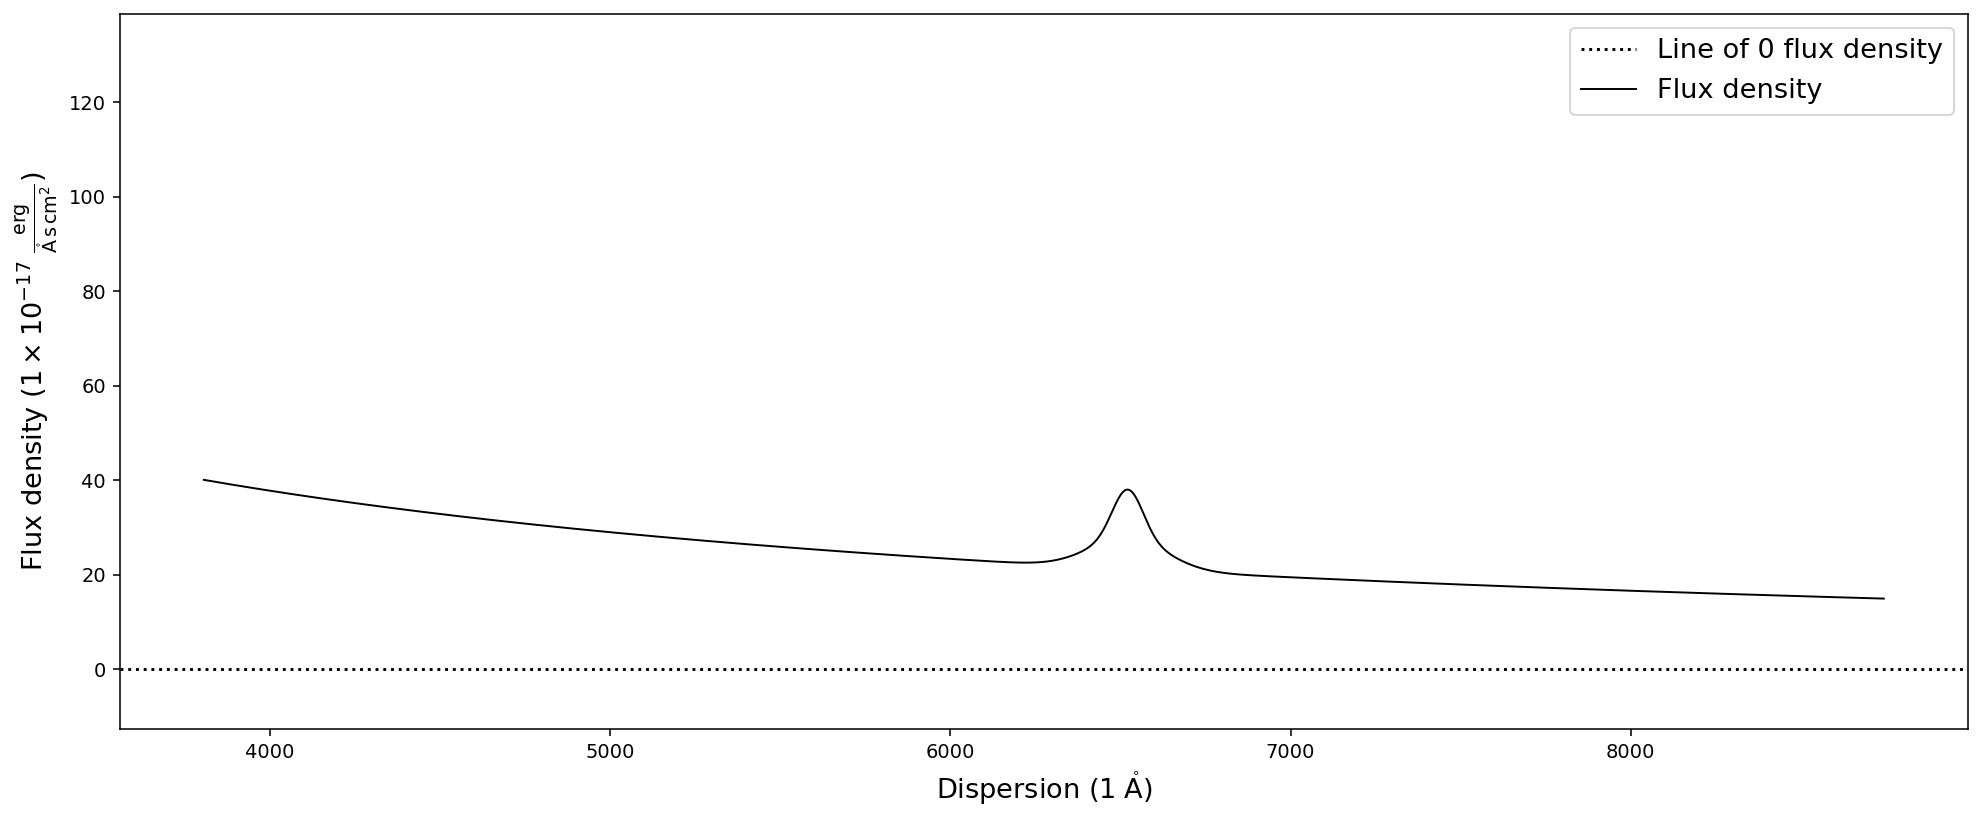

In [4]:
# Building the model flux from the CIV emission line and power law continuum model
# This is done to illustrate how the .build_model_flux function finds model functions 
# independent of their SpecModel association in the SpecFit object. 
example_model_spec = scana.build_model_flux(fit, ['CIV_A_', 'CIV_B_', 'PL_'])
example_model_spec.plot()

As you can see above the *.build_model_flux* function used both the power law continuum and the emission line Gaussians from two different *SpecModels* in the *SpecFit* object to construct the model spectrum. However, in most cases one would want to choose to analyze the continuum independent of the emission lines. Therefore, we build two model spectra below. 

In [5]:
# Build the continuum model spectrum
cont_spec = scana.build_model_flux(fit, ['PL_'])
# Build the CIV emission line model spectrum
civ_spec = scana.build_model_flux(fit, ['CIV_A_', 'CIV_B_'])

*Sculptor* offers some very high level functions for the analysis of both continuum and emission line features. However, we will first illustrate below how to derive important properties by hand using the lower level *SpecAnalysis* functionality.

## Analyzing continuum properties

We begin by analyzing the continuum. In the case of quasar spectroscopy, an important quantity is the flux/luminosity/magnitude at 1450A (rest-frame). 

### Calculating the average continuum flux density

To calculate the flux density at a specific point in the model spectrum we use the *SpecAnalysis* function **.get_average_fluxden**. It calculates the average flux density of a spectrum (SpecOneD object, first argument) in a window centered at the specified dispersion (second argument) and with a given width (keyword argument, *width=10* default). The dispersion and the width need to be in the same quantity as the dispersion axis, i.e. the unit in which the dispersion axis is plotted if you would plot your model spectrum. A redshift keyword argument (*redshift=0*, default) can be specified, which automatically translates the rest-frame central dispersion value and the rest-frame width to the observed frame.

**Note:** *Of course you can take your observed spectrum, import it as a SpecOneD object, and calculate the average continuum flux density directly from the science spectrum in regions unaffected by emission or absorption features with this function.*

In [6]:
# Calculate the average flux density at 1445-1455A rest-frame
fluxden_1450 = scana.get_average_fluxden(cont_spec, 1450,
                                         redshift=fit.redshift)

print('Average flux density at 1450A: ',fluxden_1450)

Average flux density at 1450A:  2.2770917934343433e-16 erg / (Angstrom cm2 s)


Note how the function automatically returns the **physical** value of the flux density **including** the unit. All of the *SpecAnalysis* functions are designed to work with the astropy.units package to automatically return results with units. This allows for easy conversions into different unit system and for double checking the that the returned values are actually reasonable. 

### Calculating the monochromatic continuum luminosity

In the next step we will convert the average flux density to an average **monochromatic luminosity** using the cosmology (astropy.Cosmology object) defined above.

In [7]:
lum_mono = scana.calc_lwav_from_fwav(fluxden_1450,
                                     redshift=fit.redshift,
                                     cosmology=cosmo)

print('Monochromatic luminosity at 1450A: ', lum_mono)

Monochromatic luminosity at 1450A:  8.864701317998224e+43 erg / (Angstrom s)


### Calculating the apparent monochromatic AB magnitude

We calculate the apparent magnitude from the averaged flux density. To do this we use the *SpecAnalsysis* function *calc_apparent_mag_from_fluxden*. It takes the averaged flux density as the first argument and the central observed dispersion (wavelength or frequency) of the flux density as arguments. Note that the dispersion value should be a quantity (astropy.Quantity).

In [8]:
abmag = scana.calc_apparent_mag_from_fluxden(
    fluxden_1450,
    1450*(1.+fit.redshift)*units.AA)

print('Apparent AB magnitude at 1450A: ', abmag)

Apparent AB magnitude at 1450A:  17.761599161710915 mag


### Calculating the absolute monochromatic AB magnitude

From here we can calculate the sources AB magnitude at 1450A in three different ways: 
1. Calculate the absolute magnitude from the the apparent magnitude 
2. Calculate the absolute magnitude from the flux density
3. Calculate the absolute magnitude from the monochromatic luminosity

Let's briefly go through all three possibilities.

#### Calculate the absolute magnitude from the the apparent magnitude 

We calculated the apparent magnitude above. Now we only need to convert it to the absolute magnitude. In this step we need to specify the cosmology as well as to indicate how the flux should be corrected due to the change of the filter bandpass - the K-correction. For monochromatic magnitudes this is simply a scaling factor of (1+z) in flux. 

We use the *SpecAnalysis* function *calc_absolute_mag_from_apparent_mag*, which takes the apparent magnitude as the first argument, the cosmology (astropy.Cosmology) as the second argument and the redshift as the third argument. 
At present the function only allows to add the kcorrection for spectra with a power-law type continuum (power law index *a_nu*). 

**Note:**In the case of monochromatic magnitudes, the K-correction is specified by setting the *kcorrection* keyword argument to *True* and the power law slope to *a_nu=0*, independent of the source's continuum shape. (Incidentally these are the default values.) 

(For apparent to absolute magnitude conversions for bandpass magnitudes and non-power law continua, you can still use this function setting *kcorrection=False* and then apply the appropriate K-correction factor in magnitudes yourself.)

In [9]:
abs_abmag = scana.calc_absolute_mag_from_apparent_mag(abmag, cosmo,
                                                   fit.redshift,
                                                   kcorrection=True,
                                                   a_nu=0)

print('Absolute magnitude at 1450 (from apparent magnitude): ', abs_abmag)

Absolute magnitude at 1450 (from apparent magnitude):  -27.889171135994392 mag


#### Calculate the absolute magnitude from the monochromatic luminosity

We do not need to calculate the apparent monochromatic magnitude to get to the absolute monochromatic magnitude. We can directly compute this from the flux density at 1450A using the *SpecAnalysis.calc_absolute_mag_from_fluxden* function.

However, the function goes through the same steps as we did above. Therefore, we also need to specify the K-correction and power law slope keywords on top of the monochromatic flux density (first argument), the observed dispersion (second argument), the cosmology (third argument), and the redshift (fourth argument).

In [10]:
abs_abmag2 = scana.calc_absolute_mag_from_fluxden(
    fluxden_1450, 1450*(1.+fit.redshift) * units.AA,
    cosmo, fit.redshift, kcorrection=True, a_nu=0)

print('Absolute magnitude at 1450 (from monochr. flux density): ', abs_abmag2)

Absolute magnitude at 1450 (from monochr. flux density):  -27.889171135994392 mag


#### Calculate the absolute magnitude from the monochromatic luminosity

We already calculated the monochromatic luminosity above. Of course we can directly calculate the absolute magnitude from the monochromatic luminosity. In the *SpecAnalysis* module the function *calc_absolute_mag_from_monochromatic_luminosity* does that for you. You specify the monochromatic luminosity and the corresponding **rest-frame wavelength** value as the first and second arguments. The cosmological corrections were already applied, when calculating the monochromatic luminosity above.

In [11]:
abs_abmag3 = scana.calc_absolute_mag_from_monochromatic_luminosity(lum_mono, 1450*units.AA)

print('Absolute magnitude at 1450 (from monochr. luminosity): ', abs_abmag3)

Absolute magnitude at 1450 (from monochr. luminosity):  -27.88917113599439 mag


As you can see all three functions to calculate the absolute magnitude lead to the same value of ~-27.9 mag. 

## Analyzing line properties

We now turn to calculate line properties. In our example, we will focus on the CIV emission line of the example quasar spectrum. We modeled the CIV line with two Gaussian components and stored the model flux in a *SpecOneD* object, called civ_spec. Let's first check if the model flux looks reasonable.

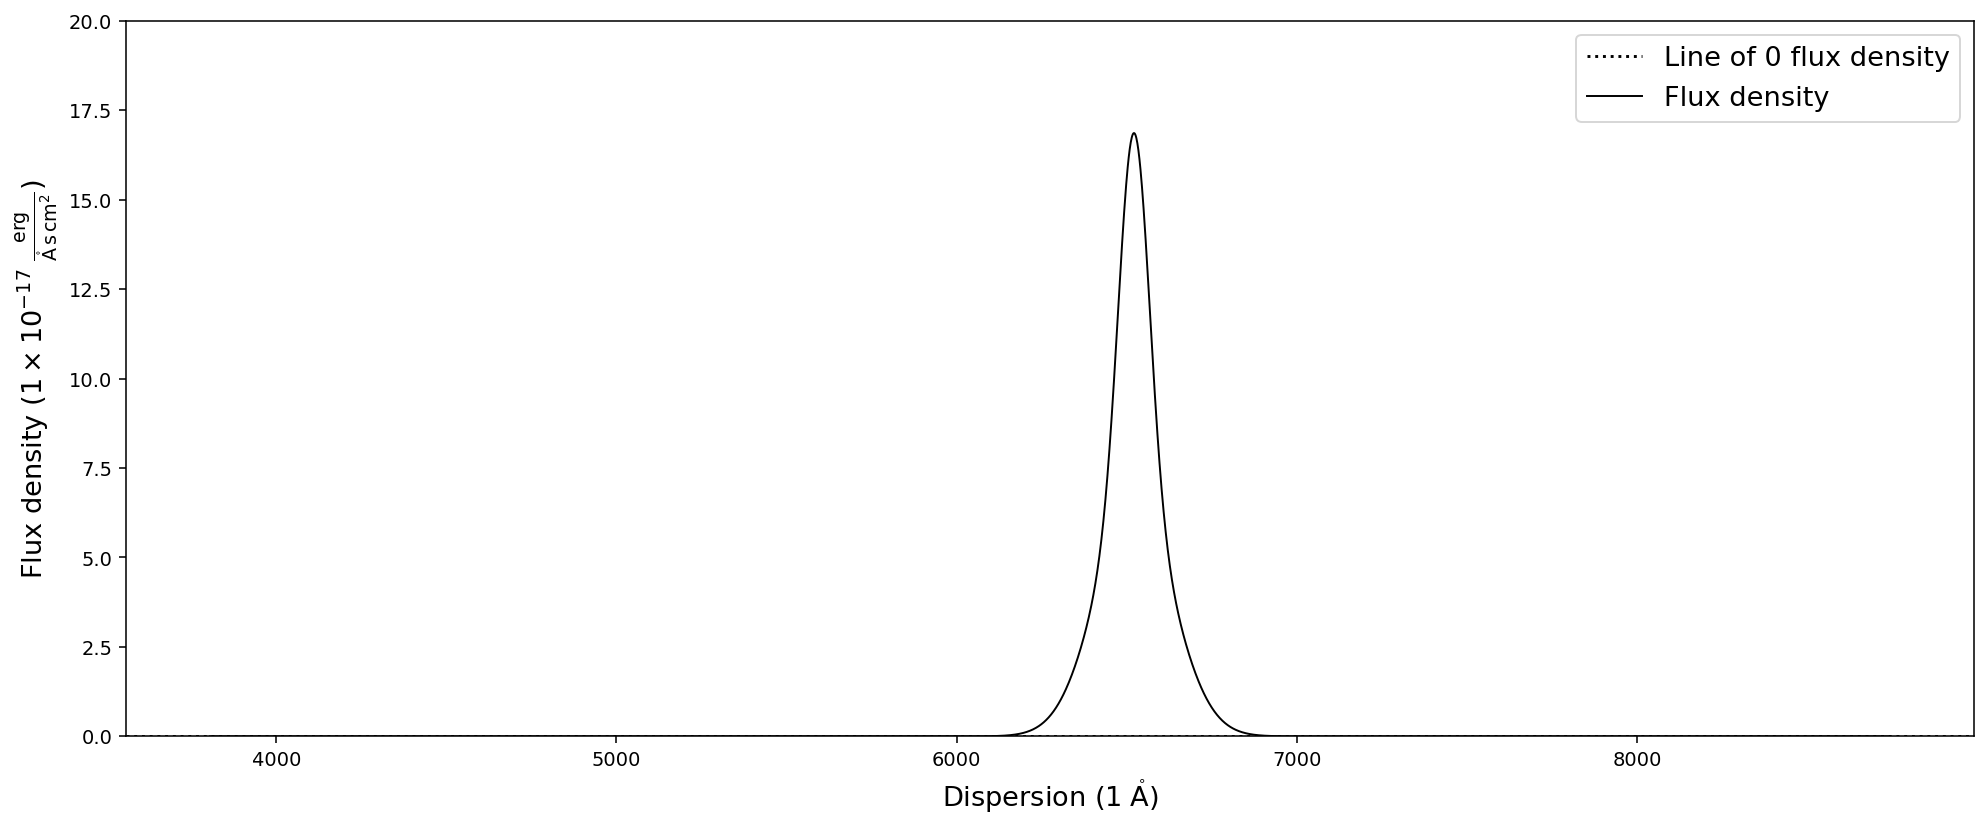

In [12]:
# Plot the CIV model flux spectrum, adjusting the y-axis limits
civ_spec.plot(ymin=0, ymax=20)

The model flux specturm look reasonable, so we can continue!

### The peak flux density

In order to calculate the peak flux density, we can rely on the *numpy* package:

In [13]:
civ_peak_fluxden = np.max(civ_spec.fluxden)*civ_spec.fluxden_unit
print('CIV peak flux density: {:.2e}'.format(civ_peak_fluxden))

CIV peak flux density: 1.69e-16 erg / (Angstrom cm2 s)


### The peak redshift

Although this calculation is quite simply, we have decided to add this functionality to the *SpecAnalysis* module with the *get_peak_redshift* function. It requires the line model spectrum and the rest-frame wavelength of the feature.

In [14]:
civ_z = scana.get_peak_redshift(civ_spec, 1549.06)
print('CIV peak redshift: {:.3f}'.format(civ_z))

CIV peak redshift: 3.210


### The line Full Width at Half Maximum (FWHM)

For line models with a single Gaussian component, the FWHM can be directly retrieved from the model function. However, for composite lines it is more difficult to define and then calculate a FWHM. 
The *SpecAnalysis* implementation for calculating the FWHM **get_fwhm**, follows the simplest definition of the FWHM: 

It calculates the peak flux density and then sets up a spline interpolation subtracting half of the peak flux density from the model spectrum. If the line model flux is well defined the resulting spline should have exactly two roots (model flux = 0). The function returns the dispersion difference between the two roots. If the line feature has multiple components more or less than two roots can be found in which case a np.NaN value will be returned.

**Correction for spectral resolution:** The keyword argument *resolution* allows to specify the spectral resolution in R = Lambda/Delta Lambda. If the *resolution* value is not *None*, the spectral resolution will be subtracted from the FWHM of the line feature (assuming FWHM_corr^2 = FWHM^2 - Resolution_km_s^2). If you specify the resolution, an info message will let you know that the function has corrected the FWHM for it. 

In [15]:
# Calculate the CIV FWHM
civ_fwhm = scana.get_fwhm(civ_spec)
print('CIV FWHM: {:.2f}'.format(civ_fwhm))

# Calculate the CIV FWHM, taking into account a spectral resolution of R=1000
civ_fwhm = scana.get_fwhm(civ_spec, resolution=1000)
print('CIV FWHM (accounting for spectral resolution): {:.2f}'.format(civ_fwhm))

CIV FWHM: 6351.91 km / s
[INFO] FWHM is corrected for the provided resolution of R=1000
CIV FWHM (accounting for spectral resolution): 6344.84 km / s


Additionally, there are two different methods for calculating the FWHM from the model spectrum. The default method 'spline' uses a spline to interpolate the original spectrum and find the zero points using a root finding algorithm on the spline. The second method 'sign'  finds sign changes in the half peak flux subtracted spectrum. 
Their results may differ depending on the dispersion resolution. From an initial test it seems that the computational cost of both methods is similar.

In [16]:
civ_fwhm = scana.get_fwhm(civ_spec)
print('CIV FWHM ("sign" method): {:.2f}'.format(civ_fwhm))

civ_fwhm = scana.get_fwhm(civ_spec, method='sign')
print('CIV FWHM ("spline" method): {:.2f}'.format(civ_fwhm))

CIV FWHM ("sign" method): 6351.91 km / s
CIV FWHM ("spline" method): 6350.92 km / s


### The integrated line flux 

The integrated line flux is easily calculated by the *get_integrated_flux* function of the *SpecAnalysis* module. By default the line model spectrum will be integrated over its full length. However, you can specify the *disp_range* keyword argument, setting the integration boundaries in units of the dispersion axis manually. 

In [17]:
civ_flux = scana.get_integrated_flux(civ_spec)
print('CIV integrated flux: {:.2e}'.format(civ_flux))

CIV integrated flux: 2.97e-14 erg / (cm2 s)


### The integrated line luminosity

In a similar fashion you can calculate the integrated line luminosity. In addition to the line model spectrum, the function takes the source redshift and the cosmology as the second and third argument. 

In [18]:
civ_line_lum = scana.calc_integrated_luminosity(civ_spec,
                                                fit.redshift,
                                                cosmo)
print('CIV integrated line luminosity: {:.2e} '.format(civ_line_lum))

CIV integrated line luminosity: 2.74e+45 erg / s 


### The line equivalent width (observed-frame/rest-frame)

An important property of an emission or absorption feature is its equivalent width. For this calculation we need both the continuum model flux (cont_spec) and the line model flux (civ_spec). In order to calculate the rest-frame equivalent width for extragalactic sources the *redshift* keyword also needs to be specified. 
In the *SpecAnalysis* module the *get_equivalent_width* function calculates the equivalent width. For our example we use the CIV redshift that we determined above in this calculation. If we don't specify the redshift, the function returns the observed-frame equivalent width.

In [19]:
# Calculate the rest-frame equivalent width
civ_ew = scana.get_equivalent_width(cont_spec, civ_spec, redshift=civ_z)
print('CIV EW (rest-frame): {:.2f}'.format(civ_ew))

# Calculate the observed-frame equivalent width
civ_ew = scana.get_equivalent_width(cont_spec, civ_spec)
print('CIV EW (observed-frame): {:.2f}'.format(civ_ew))

CIV EW (rest-frame): 33.38 Angstrom
CIV EW (observed-frame): 140.51 Angstrom


### Non-parametric measurements
Furthermore we provide a range of non-parametric measurements for emission line features. These are measurements of the fraction of cumulative flux in velocity space. The redshift and rest-frame wavelength of the emission line define the velocity zero point. Negative velocities indicate flux blueward of the line and positive velocities indicate flux redward of the line.

In the current implementation the velocities at 5%, 10%, 50%, 90% and 95% of the cumulative flux fraction are calculated. The calculation also returns the mean resolution at 50% of the cumulative flux fraction as an indication for the uncertainty introduced by the spectral resolution. 

The median velocity (velocity at 50% of the cumulative flux fraction) is also called the velocity centroid. From this we can derive the centroid frequency, centroid wavelength and the centroid redshift, which are all included in this analysis function.

The dispersion range keyword argument can be used to supply the physical dispersion limits in which the analysis should be executed.

**The non-parametric measurements are NOT included in the default line measurements (cana.emfeat_measures_default) for the high-level analysis function (see below). Specifically for the analysis of resampled results of MCMC chains the non-parametric measurements are more computationally expensive.**

In [25]:
# Use the emission feature analysis function to analyze the CIV line
civ_result = scana.analyze_emission_feature(
    fit, 'CIV', ['CIV_A_', 'CIV_B_'], 1549.06, cont_model_names=['PL_'],
    redshift=fit.redshift, emfeat_meas=['nonparam'], cosmology=cosmo)

# Print the results from the dictionary
for key in civ_result.keys():
    print('{} = {:.2e}'.format(key, civ_result[key]))

CIV_v50 = -1.24e+03 km / s
CIV_v05 = -8.37e+03 km / s
CIV_v10 = -6.35e+03 km / s
CIV_v90 = 3.89e+03 km / s
CIV_v95 = 5.92e+03 km / s
CIV_vres_at_line = 6.88e+01 km / s
CIV_freq_v50 = 4.60e+14 Hz
CIV_wave_v50 = 6.52e+03 Angstrom
CIV_redsh_v50 = 3.21e+00


## High-level SpecAnalysis routines

We have written high-level *SpecAnalysis* routines that automatically calculate a range of continuum and line properties for you using the functions described above.

### SpecAnalysis.analyze_continuum

The *analyze_continuum* routine allows for automatic continuum analysis. It takes four important arguments:
* the SpecFit object
* a list of model prefix names that make up the continuum model
* a list of rest-frame wavelengths (float) for which fluxes, luminosities and magnitudes should be calculated
* the cosmology (astropy.Cosmology)

The most important keyword argument is *cont_meas*, which stands for continuum measurements. The full list of continuum measurements available in the SpecAnalysis module is:

In [26]:
print(scana.cont_measures_default)

['fluxden_avg', 'Lwav', 'appmag', 'absmag']


By default all of these will be calculated. For the full list of keyword arguments, please directly consult the documentation. 

The function returns a dictionary with the results.

In the following example, we will analyze the continuum of the example spectrum at rest-frame wavelengths of 1450A (as above) and 1280A. 

In [27]:
# Define Cosmology for cosmological conversions
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

# Import the saved example spectrum
fit = scfit.SpecFit()
fit.load('../example_spectrum_fit')

# Use the continuum analysis function
cont_result = scana.analyze_continuum(fit, ['PL_'],
                                      [1450, 1280],
                                      cosmo, width=10)

# Print the results from the dictionary
for key in cont_result.keys():
    print('{} = {:.2e}'.format(key, cont_result[key]))

1450_fluxden_avg = 2.28e-33 erg2 / (Angstrom2 cm4 s2)
1450_Lwav = 8.86e+43 erg / (Angstrom s)
1450_appmag = 1.78e+01 mag
1450_absmag = -2.79e+01 mag
1280_fluxden_avg = 2.64e-33 erg2 / (Angstrom2 cm4 s2)
1280_Lwav = 1.03e+44 erg / (Angstrom s)
1280_appmag = 1.79e+01 mag
1280_absmag = -2.78e+01 mag


### SpecAnalysis.analyze_emission_feature

**Disclaimer**:At this point we have only implemented an automatic high-level analysis for emission features. A more general function for both absorption and emission lines or, alternatively, a separate function for absorption lines is on our To-Do list.

In similar fashion to the *analyze_continuum* function above, *analyze_emission_feature* takes four important arguments:
* the SpecFit object
* the name of the emission feature, which will be used to name the resulting measurements in the output dictionary
* a list of model names to create the emission feature flux from
* the rest-frame wavelength of the emission feature

The cosmology is a keyword argument for this function (*cosmology*, astropy.Cosmology). Another important keyword argument is *emfeat_meas*, which stands for emission feature measurements and is a list of strings. The full list of possible emission feature measurements (and the default value) is: 

In [28]:
print(scana.emfeat_measures_default)

['peak_fluxden', 'peak_redsh', 'EW', 'FWHM', 'flux', 'lum']


For a full list of all available keyword arguments, please directly consult the documentation of the *SpecAnalysis* module.

In the following example we will repeat our analysis of the CIV line from above. Note, that in order to calculate the equvialent width we also need to specify the cont_model_names to generate the continuum model flux.

In [29]:
# Use the emission feature analysis function to analyze the CIV line
civ_result = scana.analyze_emission_feature(
    fit, 'CIV', ['CIV_A_', 'CIV_B_'], 1549.06, cont_model_names=['PL_'],
    redshift=fit.redshift, emfeat_meas=None, cosmology=cosmo)

# Print the results from the dictionary
for key in civ_result.keys():
    print('{} = {:.2e}'.format(key, civ_result[key]))

CIV_peak_fluxden = 1.69e-16 erg / (Angstrom cm2 s)
CIV_peak_redsh = 3.21e+00
CIV_EW = 3.32e+01 Angstrom
CIV_FWHM = 6.35e+03 km / s
CIV_flux = 2.97e-14 erg / (cm2 s)
CIV_lum = 2.74e+45 erg / s
